# 🔥Fire Classification using Deep Convolutional Neural Networks and Transfer Learning

<center><img src='https://media4.giphy.com/media/QKUx6kHItu3ilaVMdn/200.webp?cid=ecf05e47gics2m4k7lfvntuuwai9q63i175fusn61o163gvy&rid=200.webp&ct=s' height=300px width=300px></center>





# Giải thích về Mobilenet từ v1 đến v2
Ảnh dưới đây là thành phần chính của depthwise seperable convolution\
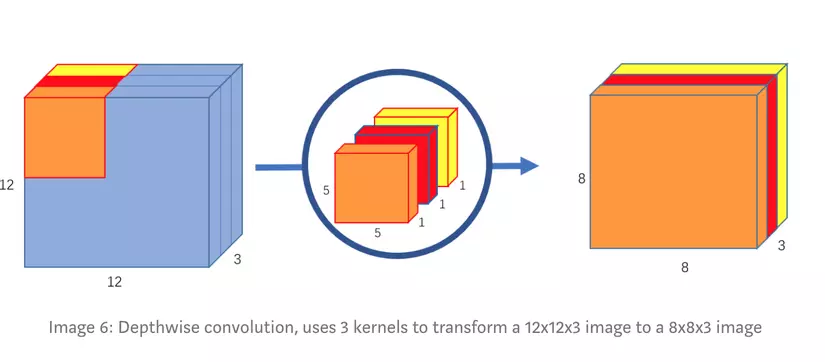\
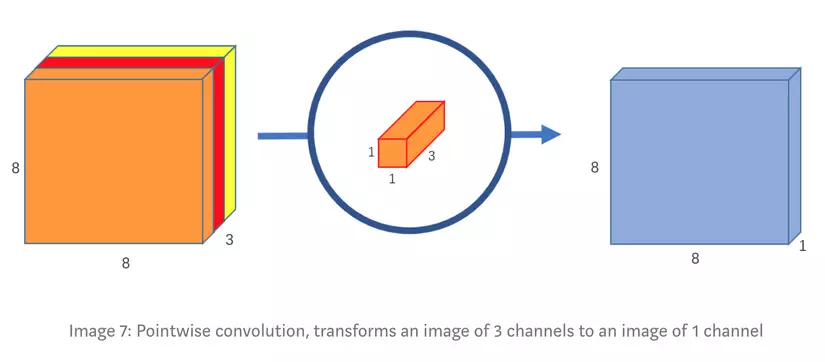

Nhìn vào ảnh, có thể thấy đầu tiên sẽ thực hiện depthwise conv, mỗi kernel sẽ thực hiện conv với mỗi channel của ảnh đầu vào, rồi sau đó gộp các kết quả vào
Sau đó sẽ thực hiện pointwise conv, sử dụng các kernel 1x1 để tính với từng điểm dữ liệu. Kernel sẽ có số channels bằng số channels của ảnh đầu vào 

**Dưới đây sẽ là mobilenetV2**
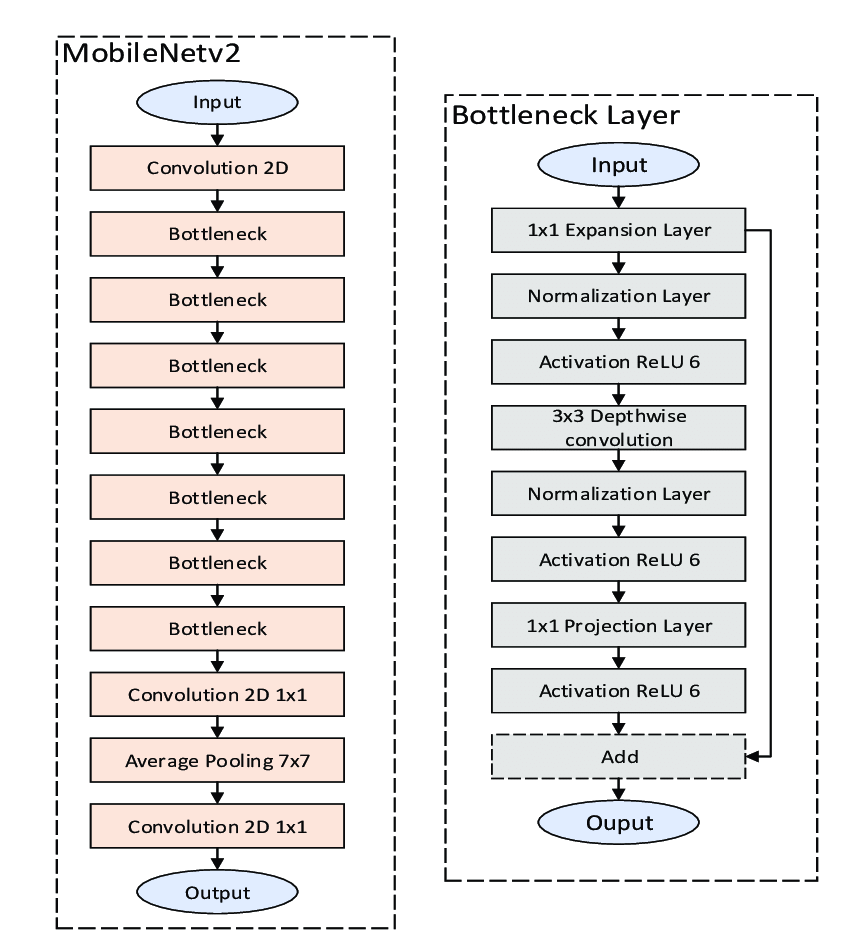
1. **Inverted Residuals**
Cấu trúc của một khối Inverted Residual bao gồm:

**Expand (Mở rộng):** Sử dụng pointwise convolution 1×1 với hàm kích hoạt phi tuyến (thường là ReLU6) để tăng số lượng kênh đầu vào, tạo ra một không gian đặc trưng rộng hơn.

**Depthwise Convolution:** Áp dụng depthwise convolution trên các kênh đã mở rộng để học các đặc trưng không gian với chi phí thấp.

**Linear Bottleneck (Project):** Sử dụng một lớp pointwise convolution 1×1 tuyến tính (không có hàm kích hoạt phi tuyến) để giảm số lượng kênh lại về kích thước ban đầu hoặc nhỏ hơn. Kết nối dư thừa (Residual Connection) cũng được sử dụng nếu kích thước đầu vào và đầu ra giống nhau và stride là 1.

2. **ReLU6 Activation Function**
MobileNet V2 sử dụng hàm kích hoạt ReLU6, một phiên bản đã sửa đổi của hàm ReLU. ReLU6 giới hạn các giá trị kích hoạt trong phạm vi [0, 6], cung cấp các thuộc tính lượng tử hóa tốt hơn để tính toán hiệu quả trên các thiết bị di động. Hàm kích hoạt này giúp đạt được sự cân bằng giữa độ chính xác và hiệu quả.

3. **Cấu trúc mạng**
MobileNet V2 sử dụng kiến ​​trúc hợp lý bao gồm:

- Lớp tích chập ban đầu : Một lớp tích chập tiêu chuẩn với 32 bộ lọc và stride là 2.
- Chuỗi các Inverted Residual Blocks : Mạng lưới bao gồm một số giai đoạn, mỗi giai đoạn có một số lượng khối dư đảo ngược cụ thể. Các yếu tố mở rộng, kênh đầu ra và bước tiến thay đổi giữa các giai đoạn để quản lý độ phức tạp tính toán và trường tiếp nhận.
- Lớp tích chập cuối cùng : Lớp tích chập 1×1 với 1280 bộ lọc, theo sau là lớp gộp trung bình toàn cục.
- Lớp Fully Connected : Lớp được kết nối đầy đủ với kích hoạt softmax cho các tác vụ phân loại.

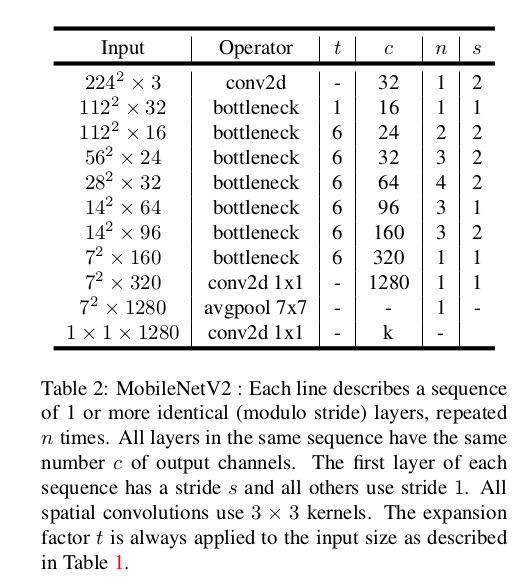

# 🏗️Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import  EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# System libraries
from pathlib import Path
import os

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# 🤙Create helper functions

In [2]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

# 📥Load and Transform Data

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [4]:
# Walk through each directory
# dataset: https://www.kaggle.com/datasets/phylake1337/fire-dataset
dataset = "../MobileNet/fire_dataset"
walk_through_dir(dataset)

There are 2 directories and 0 images in '../MobileNet/fire_dataset'.
There are 0 directories and 755 images in '../MobileNet/fire_dataset\fire_images'.
There are 0 directories and 244 images in '../MobileNet/fire_dataset\non_fire_images'.


# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
# print(labels)
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

[WindowsPath('../MobileNet/fire_dataset/fire_images/fire.1.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.10.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.100.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.101.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.102.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.103.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.104.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.105.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.106.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.107.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.108.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.109.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.11.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.110.png'), WindowsPath('../MobileNet/fire_dataset/fire_images/fire.111.png')

In [7]:
len(list(image_dir.glob(r'**/*.png')))

999

In [8]:
image_df

Filepath            Label
0     ..\MobileNet\fire_dataset\fire_images\fire.1.png      fire_images
1    ..\MobileNet\fire_dataset\fire_images\fire.10.png      fire_images
2    ..\MobileNet\fire_dataset\fire_images\fire.100...      fire_images
3    ..\MobileNet\fire_dataset\fire_images\fire.101...      fire_images
4    ..\MobileNet\fire_dataset\fire_images\fire.102...      fire_images
..                                                 ...              ...
994  ..\MobileNet\fire_dataset\non_fire_images\non_...  non_fire_images
995  ..\MobileNet\fire_dataset\non_fire_images\non_...  non_fire_images
996  ..\MobileNet\fire_dataset\non_fire_images\non_...  non_fire_images
997  ..\MobileNet\fire_dataset\non_fire_images\non_...  non_fire_images
998  ..\MobileNet\fire_dataset\non_fire_images\non_...  non_fire_images

[999 rows x 2 columns]

# 🔭Visualizing images from the dataset

In [12]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)

[349 887 973 381 102 743 779 771 532 125 225  44  62 436 196 874]


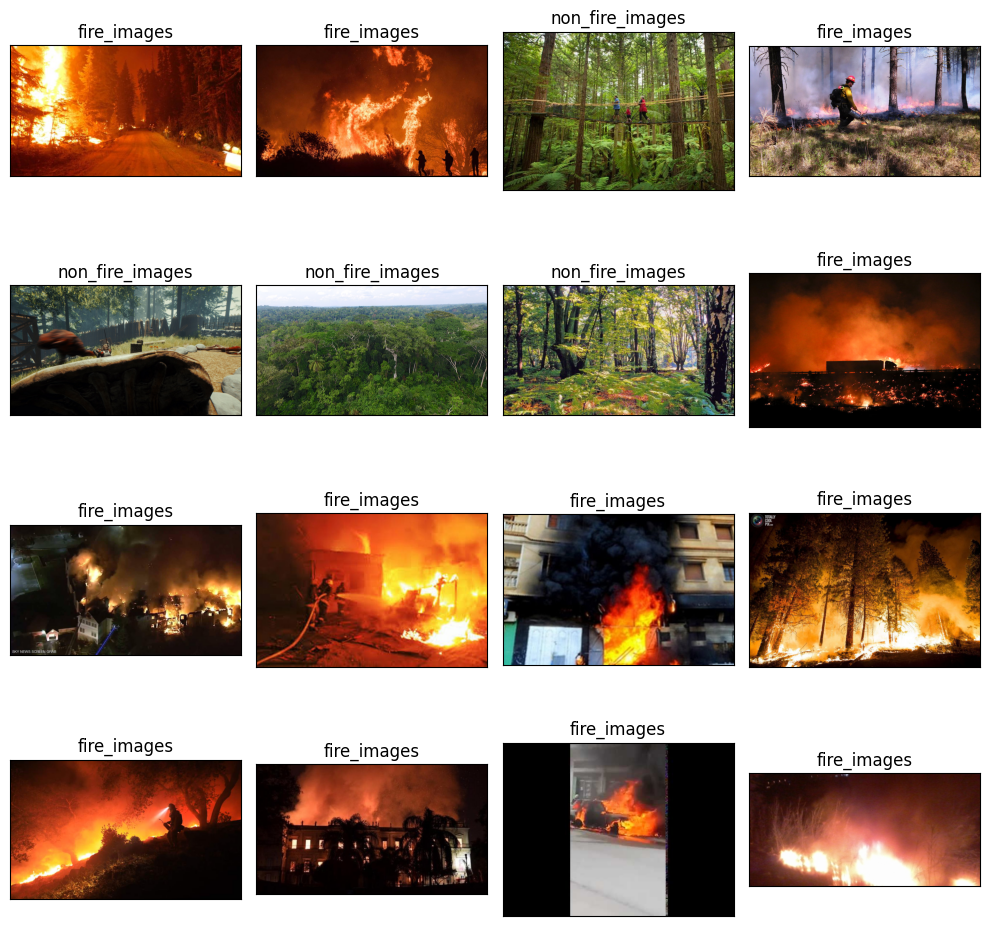

In [10]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat): 
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 📝Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [13]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [14]:
train_df

Filepath            Label
778  ..\MobileNet\fire_dataset\non_fire_images\non_...  non_fire_images
286  ..\MobileNet\fire_dataset\fire_images\fire.357...      fire_images
165  ..\MobileNet\fire_dataset\fire_images\fire.248...      fire_images
960  ..\MobileNet\fire_dataset\non_fire_images\non_...  non_fire_images
493  ..\MobileNet\fire_dataset\fire_images\fire.543...      fire_images
..                                                 ...              ...
106  ..\MobileNet\fire_dataset\fire_images\fire.195...      fire_images
270  ..\MobileNet\fire_dataset\fire_images\fire.342...      fire_images
860  ..\MobileNet\fire_dataset\non_fire_images\non_...  non_fire_images
435  ..\MobileNet\fire_dataset\fire_images\fire.491...      fire_images
102  ..\MobileNet\fire_dataset\fire_images\fire.191...      fire_images

[799 rows x 2 columns]

In [15]:
test_df

Filepath            Label
453  ..\MobileNet\fire_dataset\fire_images\fire.507...      fire_images
793  ..\MobileNet\fire_dataset\non_fire_images\non_...  non_fire_images
209  ..\MobileNet\fire_dataset\fire_images\fire.288...      fire_images
309  ..\MobileNet\fire_dataset\fire_images\fire.378...      fire_images
740  ..\MobileNet\fire_dataset\fire_images\fire.86.png      fire_images
..                                                 ...              ...
78   ..\MobileNet\fire_dataset\fire_images\fire.17.png      fire_images
29   ..\MobileNet\fire_dataset\fire_images\fire.125...      fire_images
277  ..\MobileNet\fire_dataset\fire_images\fire.349...      fire_images
261  ..\MobileNet\fire_dataset\fire_images\fire.334...      fire_images
423  ..\MobileNet\fire_dataset\fire_images\fire.480...      fire_images

[200 rows x 2 columns]

In [16]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [17]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [18]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# 🤹Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (320, 320, 3)

**Output layer** : 1



In [19]:
# Load the pretained model
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [20]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [21]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Training the model

In [22]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images), # số batch trên mỗi epochs
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20240930-081201
Epoch 1/30
20/20 [==============================] - 24s 809ms/step - loss: 0.4177 - accuracy: 0.7641 - val_loss: 0.2053 - val_accuracy: 0.9182
Epoch 2/30
20/20 [==============================] - 11s 543ms/step - loss: 0.1554 - accuracy: 0.9594 - val_loss: 0.1435 - val_accuracy: 0.9371
Epoch 3/30
20/20 [==============================] - 11s 564ms/step - loss: 0.0936 - accuracy: 0.9781 - val_loss: 0.1259 - val_accuracy: 0.9560
Epoch 4/30
20/20 [==============================] - 10s 521ms/step - loss: 0.0675 - accuracy: 0.9812 - val_loss: 0.1208 - val_accuracy: 0.9560
Epoch 5/30
20/20 [==============================] - 11s 562ms/step - loss: 0.0479 - accuracy: 0.9875 - val_loss: 0.1192 - val_accuracy: 0.9623
Epoch 6/30
20/20 [==============================] - 11s 564ms/step - loss: 0.0413 - accuracy: 0.9891 - val_loss: 0.1075 - val_accuracy: 0.9686
Epoch 7/30
20/20 [==============================] - 11s 527

# ✔️Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**: 
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [23]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06126
Test Accuracy: 98.50%


# 📉Visualizing loss curves

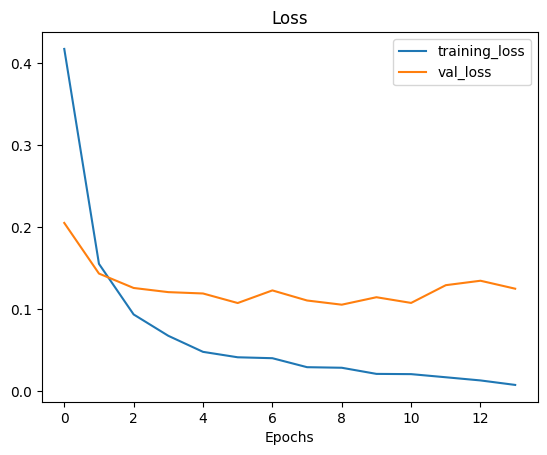

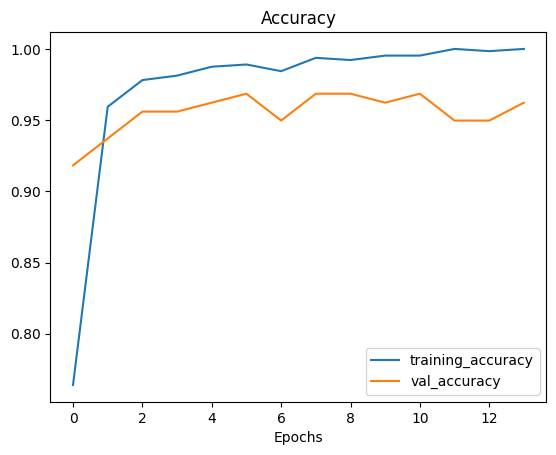

In [24]:
plot_loss_curves(history)

# 🔮Making predictions on the Test Data

In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 3s 377ms/step
The first 5 predictions: ['fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images']


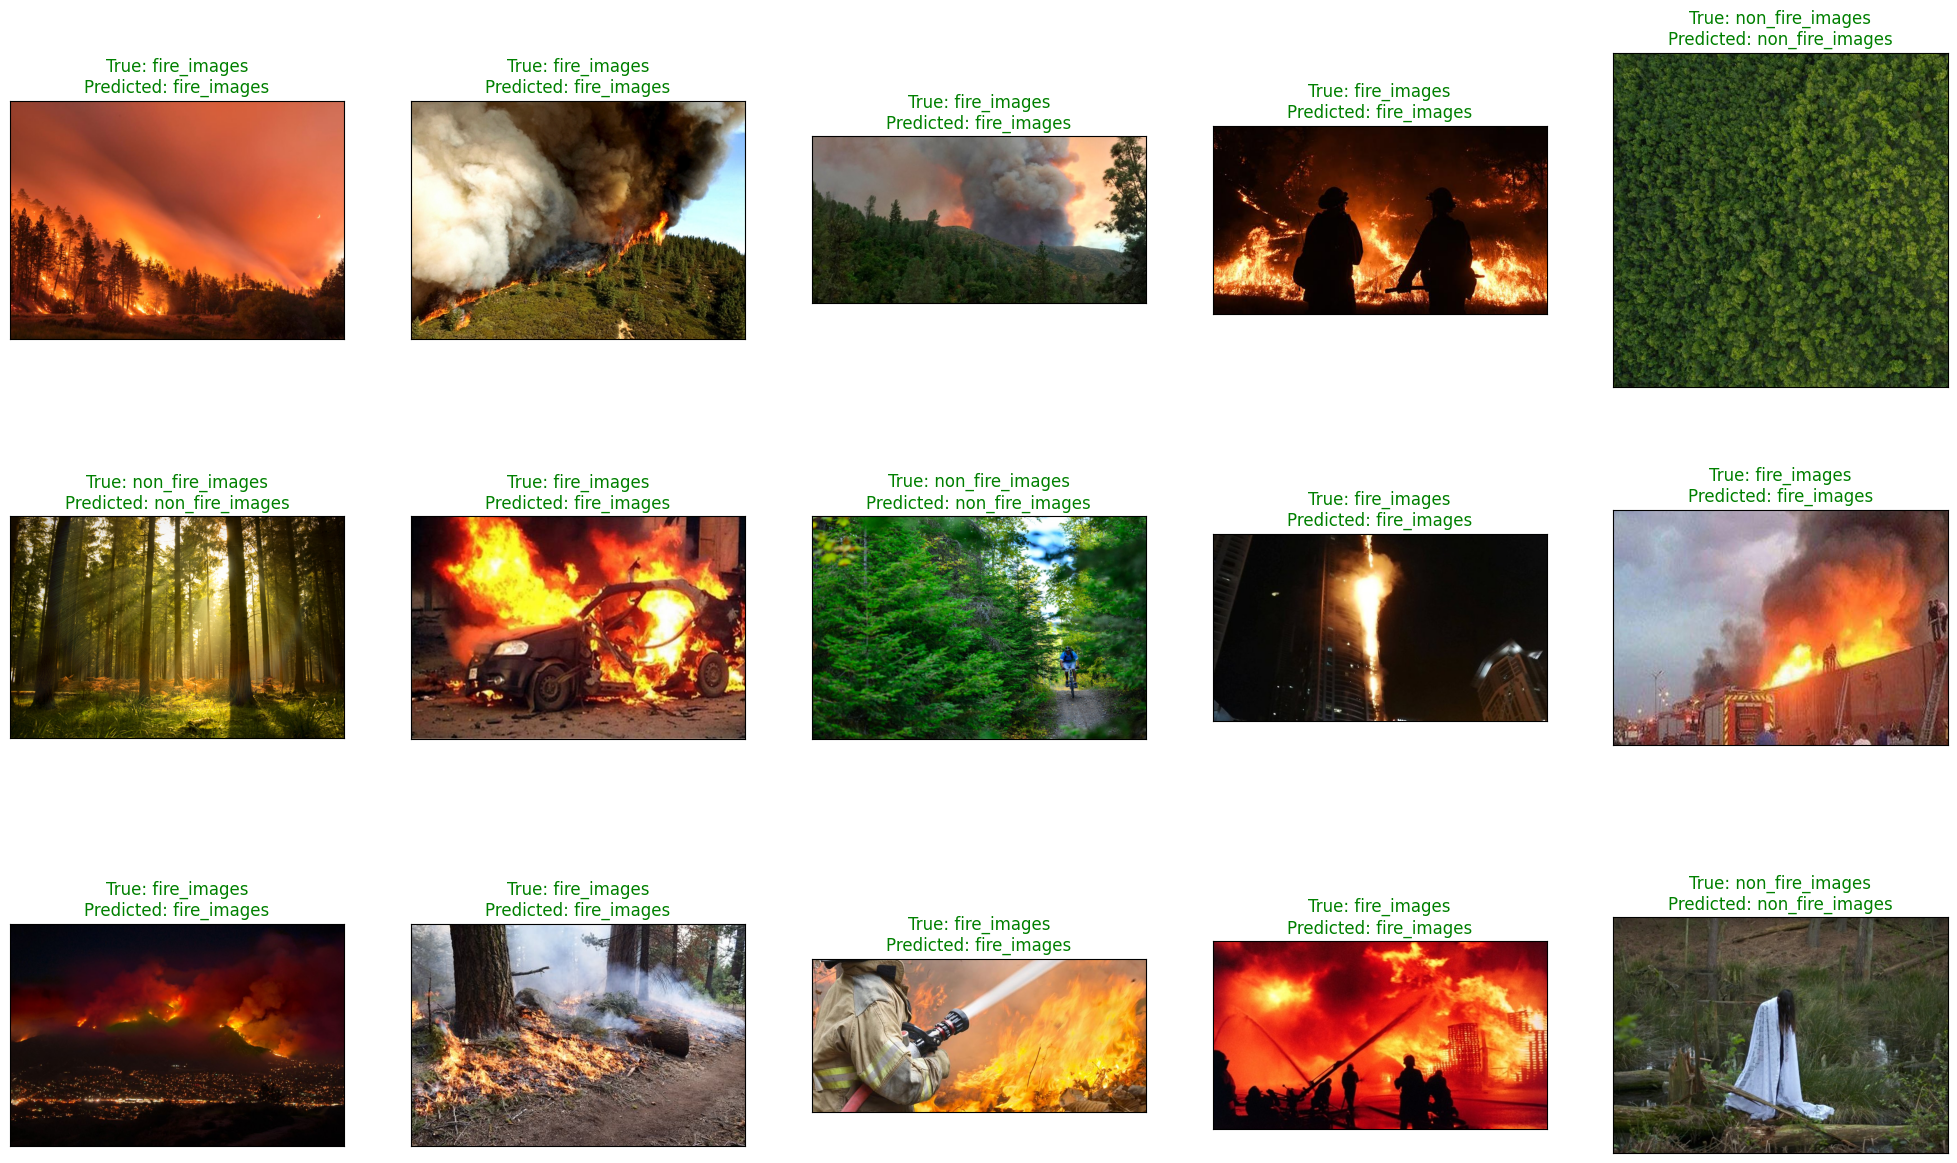

<Figure size 640x480 with 0 Axes>

In [26]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

In [27]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.98      1.00      0.99       148
non_fire_images       1.00      0.94      0.97        52

       accuracy                           0.98       200
      macro avg       0.99      0.97      0.98       200
   weighted avg       0.99      0.98      0.98       200



In [28]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
fire_images       0.980132  1.000000  0.989967  148.000
non_fire_images   1.000000  0.942308  0.970297   52.000
accuracy          0.985000  0.985000  0.985000    0.985
macro avg         0.990066  0.971154  0.980132  200.000
weighted avg      0.985298  0.985000  0.984852  200.000

In [29]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


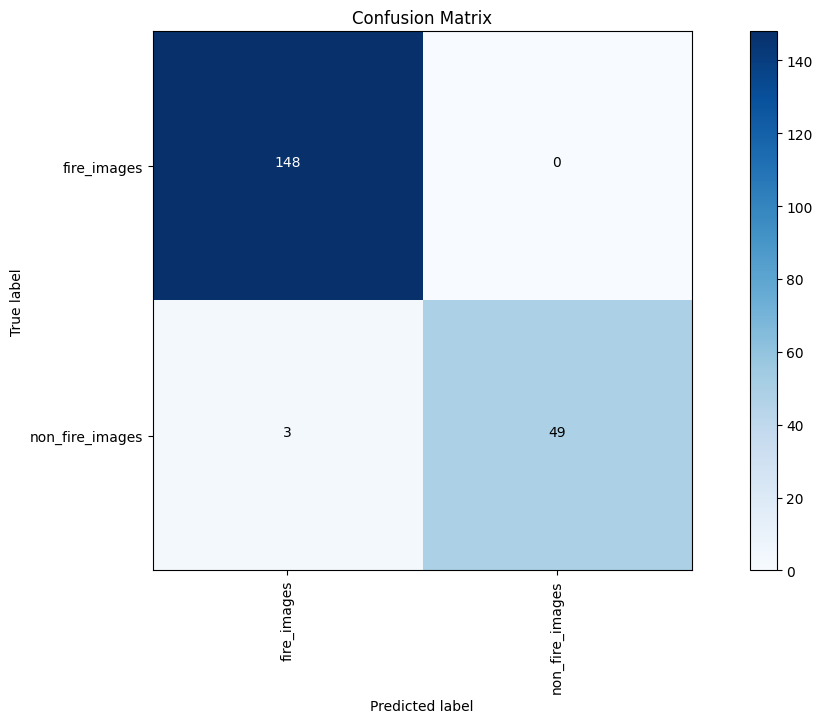

In [30]:
make_confusion_matrix(y_test, pred, list(labels.values()))

### Thanks for viewing the notebook. I would greatly appreciate any feedback, suggestions and recommendations for improvement. Cheers! 

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s' 
     height=30px width=160px /></center>